In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
# text data
df = pd.read_csv("train_df.tsv", sep="\t") 

# img descriptions
with open("D_train.pkl", "rb") as f:
    image_descriptions = pickle.load(f)
print("Image Descriptions (First 5 Records):")
for key, value in list(image_descriptions.items())[:5]:
    print(f"{key}: {value}")

print()

# detected objects
with open("O_train.pkl", "rb") as f:
    detected_objects = pickle.load(f)
print("Detected Objects (First 5 Records):")
for key, value in list(detected_objects.items())[:5]:
    print(f"{key}: {value}")

Image Descriptions (First 5 Records):
931874353976938497: people sitting on the floor in a large room with a wall
880425829246922752: two twee screens of donald trump and donald trump
690915881082343424: there are two shovels that are standing in the snow
915228456757059585: arafed view of a passenger plane with a flat screen tv
494194068998468686_25639236: cars are driving down the highway on a cloudy day

Detected Objects (First 5 Records):
931874353976938497: {'classes': ['person', 'backpack', 'handbag', 'backpack', 'backpack', 'cell phone', 'person', 'person', 'person', 'cup', 'chair', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'person', 'chair', 'person', 'person', 'person', 'backpack', 'backpack', 'person', 'person', 'person', 'backpack', 'person', 'person', 'person', 'person', 'person', 'person'], 'confidence_scores': [0.0945774, 0.0975185, 0.111666, 0.117207, 0.118647, 0.120145, 0.121325, 0.217946, 0.224531, 0.226831, 0.280922, 0.29603, 0.33

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BartTokenizer, BartForConditionalGeneration, ViTModel
from torchvision.models import vit_b_16
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import evaluate

In [4]:
class MuSEDataset(Dataset):
    
    def __init__(self, text_file, image_desc_file, obj_file, image_folder, tokenizer, max_length=256, transform=None):
        ''' Initialize the MuSEDataset class. '''
        self.text_data = pd.read_csv(text_file, sep="\t")
        
        with open(image_desc_file, "rb") as f:
            self.image_descriptions = pickle.load(f)
        
        with open(obj_file, "rb") as f:
            self.detected_objects = pickle.load(f)
        
        self.image_folder = image_folder
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
            # mean and std dev for RGB channels
        ])
        
    
    def __len__(self):
        ''' Return the length of the dataset. '''
        return len(self.text_data)
    
    def __getitem__(self, idx):
        ''' Get the data for a given index.
        Here, we get:
        1. Multimodal input (txt, img desc, obj)
        2. Explanantion and target
        Tokenize them and return a dictionary of relevant data
        '''        # Get data
        row = self.text_data.iloc[idx]
        text = row["text"]  
        explanation = row["explanation"] if "explanation" in row else ""
        image_name = str(row["pid"])  # Convert to string to match dictionary keys
        sarcasm_target = str(row["target_of_sarcasm"]) if pd.notna(row.get("target_of_sarcasm", "")) else ""

        # Preprocess img
        image_path = os.path.join(self.image_folder, f"{image_name}.jpg")
        try:
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
        except FileNotFoundError:
            # blank image if not found
            print(f"Warning: Image {image_path} not found, using blank image.")
            image = torch.zeros((3, 224, 224))

        # img desc and objects
        img_desc = self.image_descriptions.get(image_name, "No description available")
        detected_objs = self.detected_objects.get(image_name, {"classes": [], "confidence_scores": []})
        
        # formatting objs to string
        if isinstance(detected_objs, dict) and "classes" in detected_objs:
            obj_str = ", ".join(detected_objs["classes"])
        else:
            obj_str = "No objects detected"

        # multimodal input
        multimodal_text = f"Text: {text} Image: {img_desc} Objects: {obj_str}"
        
        # Tokenize inputs, explanation, target
        input_encodings = self.tokenizer(multimodal_text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        target_encodings = self.tokenizer(explanation, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        sarcasm_target_encodings = self.tokenizer(sarcasm_target, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        
        # Return the data as a dictionary
    
        return {
            "input_ids": input_encodings["input_ids"].squeeze(0),
            "attention_mask": input_encodings["attention_mask"].squeeze(0),
            "image": image,
            "target_ids": target_encodings["input_ids"].squeeze(0),
            "target_attention_mask": target_encodings["attention_mask"].squeeze(0),
            "sarcasm_target_ids": sarcasm_target_encodings["input_ids"].squeeze(0),
            "sarcasm_target_mask": sarcasm_target_encodings["attention_mask"].squeeze(0),
            "raw_text": text,
            "raw_explanation": explanation
        }

In [5]:
class ImageProjection(nn.Module):
    """Projects ViT image features to match BART embedding dimensions"""
    
    def __init__(self, input_dim=768, output_dim=768):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        return self.linear(x)

class CrossModalAttention(nn.Module):
    """Computes cross-modal attention between text and vision features"""
    
    def __init__(self, feature_dim=768):
        super().__init__()
        
        self.query_v = nn.Linear(feature_dim, feature_dim)
        self.key_v = nn.Linear(feature_dim, feature_dim)
        self.value_v = nn.Linear(feature_dim, feature_dim)
        
        self.query_t = nn.Linear(feature_dim, feature_dim)
        self.key_t = nn.Linear(feature_dim, feature_dim)
        self.value_t = nn.Linear(feature_dim, feature_dim)
        
        self.dropout = nn.Dropout(0.1)
        self.scale = feature_dim ** 0.5
        
    def forward(self, vision_features, text_features):
        # self-attention for vision 
        q_v = self.query_v(vision_features)
        k_v = self.key_v(vision_features)
        v_v = self.value_v(vision_features)
        
        attn_v = torch.matmul(q_v, k_v.transpose(-2, -1)) / self.scale
        attn_v = F.softmax(attn_v, dim=-1)
        attn_v = self.dropout(attn_v)
        Av = torch.matmul(attn_v, v_v)
        
        # self-attention for text 
        q_t = self.query_t(text_features)
        k_t = self.key_t(text_features)
        v_t = self.value_t(text_features)
        
        attn_t = torch.matmul(q_t, k_t.transpose(-2, -1)) / self.scale
        attn_t = F.softmax(attn_t, dim=-1)
        attn_t = self.dropout(attn_t)
        At = torch.matmul(attn_t, v_t)
        
        # cross modal
        Ftv = At * vision_features
        Fvt = Av * text_features
        
        return Ftv, Fvt

class GatedFusion(nn.Module):
    """Gated fusion mechanism to dynamically weigh features"""
    
    def __init__(self, feature_dim=768):
        super().__init__()
        self.Wv = nn.Linear(feature_dim, feature_dim)
        self.Wt = nn.Linear(feature_dim, feature_dim)
        self.bv = nn.Parameter(torch.zeros(feature_dim))
        self.bt = nn.Parameter(torch.zeros(feature_dim))
    
    def forward(self, Ev, Et, Ftv, Fvt):
        # Gate for controlling information flow
        Gv = torch.sigmoid(self.Wv(Ev) + self.bv)
        Gt = torch.sigmoid(self.Wt(Et) + self.bt)
        
        # Multimodal features
        F1 = (Gv * Ftv) + ((1 - Gv) * Fvt)
        F2 = (Gt * Ftv) + ((1 - Gt) * Fvt)

        # Unimodal features
        Fv = (Gv * Ev) + ((1 - Gv) * Ftv)
        Ft = (Gt * Et) + ((1 - Gt) * Fvt)

        return F1, F2, Fv, Ft

class SharedFusion(nn.Module):
    """Shared fusion mechanism that combines multimodal and unimodal features"""
    
    def __init__(self, feature_dim=768):
        super().__init__()
        self.alpha1 = nn.Parameter(torch.ones(1))
        self.alpha2 = nn.Parameter(torch.ones(1))
        self.beta1 = nn.Parameter(torch.ones(1))
        self.beta2 = nn.Parameter(torch.ones(1))
    
    def forward(self, F1, F2, Fv, Ft):
        # Linear combination
        FSF = self.alpha1 * F1 + self.alpha2 * F2 + self.beta1 * Fv + self.beta2 * Ft
        return FSF

class MuSEModel(nn.Module):
    """Complete MuSE model for sarcasm explanation generation"""
    
    def __init__(self, feature_dim=768, max_length=256):
        super().__init__()
        # Vision - ViT
        self.vit = vit_b_16(weights="IMAGENET1K_V1")
        self.vit.heads = nn.Identity()  # Remove classification head
        self.image_projection = ImageProjection(feature_dim, feature_dim)
        
        # Text - BART
        self.bart = BartForConditionalGeneration.from_pretrained("facebook/bart-base")
        
        # Cross-modal attention
        self.cross_modal_attention = CrossModalAttention(feature_dim)
        
        # Fusion components
        self.gated_fusion = GatedFusion(feature_dim)
        self.shared_fusion = SharedFusion(feature_dim)
        
        # Dimensions and positioning
        self.feature_dim = feature_dim
        self.max_length = max_length
        
        # Target information projection 
        self.target_projection = nn.Linear(feature_dim, feature_dim)
        # Final projection (match BART dimensions)
        self.output_projection = nn.Linear(feature_dim, feature_dim)
        
        print("Initializing MuSEModel...")
        
    def embed_text(self, input_ids, attention_mask):
        """Extract text embeddings using BART encoder"""
        encoder_outputs = self.bart.get_encoder()(  # Direct encoder access
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        return encoder_outputs.last_hidden_state
    
    def embed_image(self, images):
        """Extract image embeddings using ViT"""
        
        with torch.no_grad():
            image_features = self.vit(images)
        return self.image_projection(image_features)
        
    def forward(self, input_ids, attention_mask, images, target_ids=None, sarcasm_target_ids=None, sarcasm_target_mask=None):
        '''
        Et - text embeddings
        Ev - vision embeddings
        
        Ftv, Fvt - cross modal attention(Et,Ev)
        
        F1, F2, Fv, Ft - gated fusion(Ev, Et, Ftv, Fvt)
        FSF - shared fusion(F1, F2, Fv, Ft)
        Z - final output
        '''
        
        batch_size = input_ids.size(0)
        
        # Et is embeddings for (text + target)
        
        Et = self.embed_text(input_ids, attention_mask)
        if sarcasm_target_ids is not None and sarcasm_target_mask is not None:
            target_embed = self.embed_text(sarcasm_target_ids, sarcasm_target_mask)
            target_embed = self.target_projection(target_embed)
            Et = Et + target_embed
        
        # Ev - vision embeddings -> reshape to match text embeddings size   
        Ev = self.embed_image(images)
        Ev = Ev.unsqueeze(1).expand(-1, self.max_length, -1)
        
        # Cross-modal attention
        Ftv, Fvt = self.cross_modal_attention(Ev, Et)
        
        # Gated fusion
        F1, F2, Fv, Ft = self.gated_fusion(Ev, Et, Ftv, Fvt)
        
        # Shared fusion
        FSF = self.shared_fusion(F1, F2, Fv, Ft)
        
        # Final proj
        Z = self.output_projection(FSF) + Et 
    
        if target_ids is not None:
            
            target_length = target_ids.size(1)
            Z = Z[:, :target_length, :]
            
            # Pass to BART with proper dimensions
            outputs = self.bart(
                encoder_outputs=(Z,),
                attention_mask=attention_mask,
                labels=target_ids,
                return_dict=True
            )
            return outputs
        else:
            # Inference mode - generate text
            generated_ids = self.bart.generate(
                encoder_outputs=(Z,),  # Proper tuple format
                attention_mask=attention_mask,
                max_length=100,
                num_beams=5,
                early_stopping=True
            )
            return generated_ids


In [6]:
import gc
def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    num_batches = len(dataloader)
    print(f"Total number of batches: {num_batches}")
    
    if num_batches == 0:
        raise ValueError("Dataloader is empty!")
        
    for batch_idx, batch in enumerate(dataloader):
        try:
            
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            target_ids = batch["target_ids"].to(device)
            sarcasm_target_ids = batch["sarcasm_target_ids"].to(device)
            sarcasm_target_mask = batch["sarcasm_target_mask"].to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                images=images,
                target_ids=target_ids,
                sarcasm_target_ids=sarcasm_target_ids,
                sarcasm_target_mask=sarcasm_target_mask
            )
            
            # Calculate loss
            loss = outputs.loss
            if batch_idx % 20 == 0:  # Print every 10 batches
                print(f"Batch {batch_idx} loss: {loss.item():.4f}")
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        except Exception as e:
            print(f"Error in batch {batch_idx}: {str(e)}")
            raise e
            
    avg_loss = total_loss / num_batches
    print(f"Epoch complete. Average loss: {avg_loss:.4f}")
    return avg_loss


def validate(model, dataloader, tokenizer, device, num_samples=5):
    model.eval()
    val_loss = 0
    generated_explanations = []
    reference_explanations = []
    sample_results = []
    
    with torch.no_grad():
        for idx, batch in enumerate(dataloader):
            # Move inputs to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            images = batch["image"].to(device)
            target_ids = batch["target_ids"].to(device)
            sarcasm_target_ids = batch["sarcasm_target_ids"].to(device)
            sarcasm_target_mask = batch["sarcasm_target_mask"].to(device)
            
            # Forward pass with teacher forcing for loss calculation
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                images=images,
                target_ids=target_ids,
                sarcasm_target_ids=sarcasm_target_ids,
                sarcasm_target_mask=sarcasm_target_mask
            )
            
            # Get loss
            loss = outputs.loss
            val_loss += loss.item()
            
            #  get explanations
            generated_ids = model.bart.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=100,
                num_beams=5,
                early_stopping=True
            )
            
            # decode explanations
            for i in range(input_ids.size(0)):
                gen_text = tokenizer.decode(generated_ids[i], skip_special_tokens=True)
                ref_text = tokenizer.decode(target_ids[i], skip_special_tokens=True)
                
                generated_explanations.append(gen_text)
                reference_explanations.append(ref_text)
                
                # Save sample results for display
                if len(sample_results) < num_samples:
                    original_text = batch["raw_text"][i]
                    sample_results.append({
                        "text": original_text,
                        "generated": gen_text,
                        "reference": ref_text
                    })
    
    rouge = evaluate.load("rouge")
    rouge_results = rouge.compute(
        predictions=generated_explanations,
        references=reference_explanations
    )
    
    bleu = evaluate.load("bleu")
    bleu_results = bleu.compute(
        predictions=generated_explanations,
        references=[[r] for r in reference_explanations]
    )
    
    # Calculate average loss
    avg_loss = val_loss / len(dataloader)
    
    return {
        "loss": avg_loss,
        "rouge": rouge_results,
        "bleu": bleu_results,
        "samples": sample_results[:5]
    }

def train_model(model, train_loader, val_loader, tokenizer, device, 
                 epochs=20, lr=0.001, checkpoint_dir="checkpoints"):
    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # optimizer
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    
    train_losses = []
    val_losses = []
    rouge_scores = []
    bleu_scores = []
    
    # Training loop
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        # train - 1 epoch
        print(f"Training on epoch {epoch + 1}...")
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        print(f"Training Loss: {train_loss:.4f}")
        
        # validate
        val_results = validate(model, val_loader, tokenizer, device)
        val_losses.append(val_results["loss"])
        rouge_scores.append(val_results["rouge"]["rougeL"])
        bleu_scores.append(val_results["bleu"]["bleu"])
        
        print(f"Validation Loss: {val_results['loss']:.4f}")
        print(f"ROUGE-L: {val_results['rouge']['rougeL']:.4f}")
        print(f"BLEU: {val_results['bleu']['bleu']:.4f}")
        
        # sample results
        print("\nSample Results:")
        for i, sample in enumerate(val_results["samples"]):
            print(f"Example {i+1}:")
            print(f"Text: {sample['text']}")
            print(f"Generated: {sample['generated']}")
            print(f"Reference: {sample['reference']}")
            print()
        
        # save checkpt
        checkpoint_path = os.path.join(checkpoint_dir, f"muse_model_epoch_{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_results["loss"],
        }, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
        
        # Clear GPU memory
        torch.cuda.empty_cache()
        gc.collect()
    
    # Plot training progress
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(rouge_scores)
    plt.xlabel('Epoch')
    plt.ylabel('ROUGE-L')
    
    plt.subplot(1, 3, 3)
    plt.plot(bleu_scores)
    plt.xlabel('Epoch')
    plt.ylabel('BLEU')
    
    plt.tight_layout()
    plt.savefig(os.path.join(checkpoint_dir, 'training_progress.png'))
    plt.show()
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'rouge_scores': rouge_scores,
        'bleu_scores': bleu_scores
    }

In [7]:
import gc

def train_and_validate():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    seed = 42
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # BART tokenizer
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    
    from torch.utils.data import Subset

    # Full training dataset
    train_dataset = MuSEDataset(
        text_file="train_df.tsv", 
        image_desc_file="D_train.pkl", 
        obj_file="O_train.pkl", 
        image_folder="images", 
        tokenizer=tokenizer
    )

    # Create a subset of the first 100 samples for training
    train_indices = list(range(100))
    train_subset = Subset(train_dataset, train_indices)

    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        train_dataset, [train_size, val_size]
    )
    
    # dataloaders
    batch_size = 4
    train_loader = DataLoader(
        train_dataset, 
        batch_size=4, 
        shuffle=True, 
        num_workers=0
    )
    
    print(f"Train dataset size: {len(train_loader.dataset)}")
    print(f"Number of batches: {len(train_loader)}")
        
    val_loader = DataLoader(
        val_dataset, 
        batch_size=4, 
        shuffle=False, 
        num_workers=0
    )
    
    print(len(val_loader.dataset))

        # model
    model = MuSEModel().to(device)
    
    # train
    train_results = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        tokenizer=tokenizer,
        device=device,
        epochs=20,
        lr=1e-4,
        checkpoint_dir="checkpoints"
    )
    
    print("Training complete.")
    
    print("Saving final model...")
    
    # Save final model
    model_path = os.path.join("checkpoints", "final_model.pt")
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to {model_path}")
    
    return model, train_results

def test_model(model_path="checkpoints/final_model.pt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Load tokenizer
    tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
    
    # Load model
    model = MuSEModel().to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # Load test data
    test_dataset = MuSEDataset(
        text_file="test_df.tsv", 
        image_desc_file="D_test.pkl", 
        obj_file="O_test.pkl", 
        image_folder="images", 
        tokenizer=tokenizer
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=4, 
        shuffle=False, 
        num_workers=0
    )
    
    # Evaluate
    test_results = validate(model, test_loader, tokenizer, device)
    
    # Save predictions
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            outputs = model.generate(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                max_length=50
            )
            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            predictions.extend(preds)
    
    with open("test_predictions.txt", "w") as f:
        for pred in predictions:
            f.write(pred + "\n")
    
    print("\nTest Results:")
    print(f"Loss: {test_results['loss']:.4f}")
    print(f"ROUGE-1: {test_results['rouge']['rouge1']:.4f}")
    print(f"ROUGE-2: {test_results['rouge']['rouge2']:.4f}")
    print(f"ROUGE-L: {test_results['rouge']['rougeL']:.4f}")
    print(f"BLEU: {test_results['bleu']['bleu']:.4f}")
    
    return test_results

Using device: cuda
Train dataset size: 2684
Number of batches: 671
299
Initializing MuSEModel...
Epoch 1/20
Training on epoch 1...
Total number of batches: 671
Batch 0 loss: 16.8491
Batch 20 loss: 4.8050
Batch 40 loss: 0.6933
Batch 60 loss: 0.5533
Batch 80 loss: 0.2408
Batch 100 loss: 0.2784
Batch 120 loss: 0.1332
Batch 140 loss: 0.1972
Batch 160 loss: 0.1331
Batch 180 loss: 0.1876
Batch 200 loss: 0.1613
Batch 220 loss: 0.1350
Batch 240 loss: 0.1517
Batch 260 loss: 0.1078
Batch 280 loss: 0.1562
Batch 300 loss: 0.1048
Batch 320 loss: 0.1180
Batch 340 loss: 0.1193
Batch 360 loss: 0.0742
Batch 380 loss: 0.1566
Batch 400 loss: 0.0793
Batch 420 loss: 0.2230
Batch 440 loss: 0.1948
Batch 460 loss: 0.1816
Batch 480 loss: 0.1361
Batch 500 loss: 0.1486
Batch 520 loss: 0.1037
Batch 540 loss: 0.1800
Batch 560 loss: 0.0842
Batch 580 loss: 0.0913
Batch 600 loss: 0.1358
Batch 620 loss: 0.1354
Batch 640 loss: 0.1047
Batch 660 loss: 0.2649
Epoch complete. Average loss: 0.5087
Training Loss: 0.5087
Vali

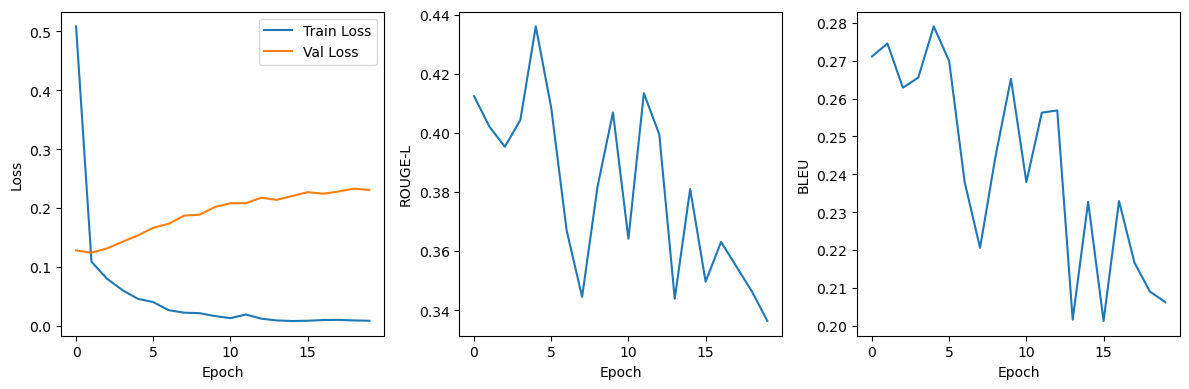

Training complete.
Saving final model...
Model saved to checkpoints\final_model.pt


In [8]:
model, train_results = train_and_validate()

In [9]:
test_results = test_model()

Using device: cuda
Initializing MuSEModel...


C:\Users\Akshat\AppData\Local\Temp\ipykernel_13776\1689813157.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


FileNotFoundError: [Errno 2] No such file or directory: 'test_df.tsv'